# 1.4: Curve fitting to noisy data #

*Andrew Valentine & Malcolm Sambridge - Research School of Earth Sciences, The Australian National University - Last updated Sept. 2019*

Imagine that you have a parameter estimation problem where you wish to
fit the following function to some observations of
$x_i, y_i, (i=1\dots,N)$

$$ y(x) = \frac{1}{100}\left[ \frac{m_1}{5} + \frac{m_2}{5}x +\frac{m_3}{16}(x^2 + 1600\sin(\frac{x}{2\pi})) \right ]. $$

<img src="./Figures/Example-data-curve.png" alt="Example of test data for regression problem with true curve (blue). Here the $x$ values are generated uniformly randomly between 0 and 120, while the $y$ values are equal to the curve height plus a Gaussian random error with $\sigma_y = 0.75$, i.e. $y_{obs} = y_{true} + \epsilon$, where $\epsilon \sim N(0, \sigma_y^2)$." width="600"/>

Figure 1. Example of test data for regression problem with true curve (blue). Here the $x$ values are generated uniformly randomly between 0 and 120, while the $y$ values are equal to the curve height plus a Gaussian random error with $\sigma_y = 0.75$, i.e. $y_{obs} = y_{true} + \epsilon$, where $\epsilon \sim N(0, \sigma_y^2)$.

In Figure 1 I have used $m_1 = m_2 = m_3 = 1.0$ to generate the true curve.


First load some libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pickle
from inversionCourse import plotcovellipse as pc

We now read in a data set of 12 value for this curve and plot them. This
    is the test data for your problem.

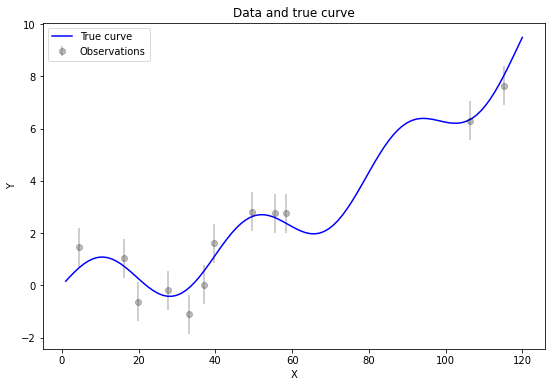

In [2]:
xmin, xmax, nres = 1.0, 120.0, 100
#
# read in observations
#
pickle_off = open("Datasets/data_fitting.pickle","rb")
[yobs,xobs,x_fine,y_fine] = pickle.load(pickle_off)
sigmay = 0.75

# ----------------------------------------------------------------------------   
# plot data
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(x_true, y_true,label='True curve',color='b')
ax.errorbar(xobs,yobs,yerr=sigmay,fmt='o',color=(0, 0, 0, 0.25),label='Observations')
plt.legend(loc='upper left',framealpha=0.7)
plt.title('Data and true curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [3]:
xobs**2/500

array([ 0.03883023,  0.52635643,  0.77937691,  1.5327059 ,  2.18460794,
        2.74993908,  3.1623535 ,  4.93055634,  6.17354537,  6.80129591,
       22.5990315 , 26.49787371])

**Task 1:** 
    We want to estimate the parameters $(m_1, m_2, m_3)$ from the
    observations. This problem can be written in vector form as
    ${\bf d} = G {\bf m}$. 
    
   Describe what are ${\bf d}$, ${\bf m}$ and
    $G$ for this problem?
    
   What dimensions does the $G$ matrix have? 
    
   Is this a linear or nonlinear parameter estimation problem and why? 
    
The G matrix can be used to find the $y$ values of the curve from the $x$ values and the $m$ parameters, through ${\bf d} = G {\bf m}$ 

Calculate the $G$ matrix for this problem corresponding to the 12 $x$ values of the data.
  

In [4]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Calculate G_true
G_true = np.transpose([np.ones(len(x_true))/500., x_true/500., x_true*x_true/1600.+1.0*np.sin(x_true/(2.0*np.pi))])
G = np.transpose([np.ones(len(xobs))/500., xobs/500., xobs*xobs/1600.+1.0*np.sin(xobs/(2.0*np.pi)),]) # G matrix
# G matrix
print(G)

[[ 2.00000000e-03  8.81251723e-03  6.57328953e-01]
 [ 2.00000000e-03  3.24455367e-02  6.95383535e-01]
 [ 2.00000000e-03  3.94810565e-02  2.43345291e-01]
 [ 2.00000000e-03  5.53661612e-02 -4.74427904e-01]
 [ 2.00000000e-03  6.61000445e-02 -1.71042053e-01]
 [ 2.00000000e-03  7.41611634e-02  4.86924637e-01]
 [ 2.00000000e-03  7.95280265e-02  1.03367378e+00]
 [ 2.00000000e-03  9.93031353e-02  2.53963212e+00]
 [ 2.00000000e-03  1.11117464e-01  2.47920530e+00]
 [ 2.00000000e-03  1.16630150e-01  2.26855702e+00]
 [ 2.00000000e-03  2.12598361e-01  6.12655426e+00]
 [ 2.00000000e-03  2.30208052e-01  7.77489588e+00]]


**Task 2:** Use the $G$ matrix and your data to estimate a least squares
    solution for the parameters $(m_1,m_2,m_3)$. Calculate the curve
    that this solution predicts and plot it with the data, its
    errors and the true curve.

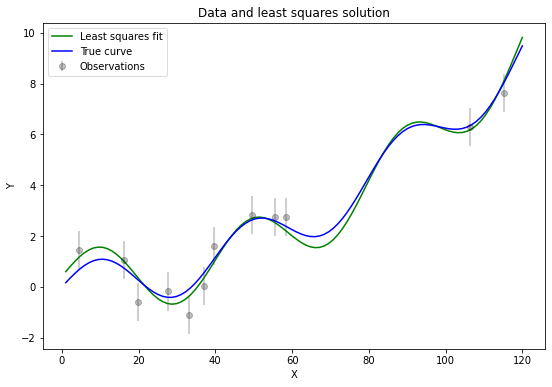

 Best fit solution =  [208.4233955   -8.86657557   1.24702922]


In [5]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

sigmay = 0.75 # Standard deviation of noise
ndata = len(yobs) # Number of data

Cdinv = np.eye(ndata)/(sigmay**2) # Inverse Data covariance matrix

A = np.dot(np.transpose(G), Cdinv)
GtG = np.dot(A, G) # G^T C_inv G^T
GtGinv = np.linalg.inv(GtG) # Inverse of G^TC_inv G
B = np.dot(A,yobs)
mls = np.dot(GtGinv, B) # Least squares solution 
     
ypredicted = np.dot(G_true,mls) # predicted y values from least squares solution

# plot data estimated solution with data

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(x_true, ypredicted,label='Least squares fit',color='g')
ax.plot(x_true, y_true,label='True curve',color='b')
ax.errorbar(xobs,yobs,yerr=sigmay,fmt='o',color=(0, 0, 0, 0.25),label='Observations')
plt.legend(loc='upper left',framealpha=0.7)
plt.title('Data and least squares solution')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(' Best fit solution = ',mls)

**Task 3:** Calculate the Chi-square value for this problem. Is this a good
        enough fit to data? Calculate the p-value for this goodness of
        fit. What do you conclude from the p-value?

Repeat the calculation with the noise error, $\sigma_y=0.25$.
        How would this change the Chi-square and p-value? What would you
        conclude in this case?

Repeat the calculation with the noise error, $\sigma_y=2.25$.
        How would this change the Chi-square and p-value? What would you
        conclude in this case?

In [6]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# ----------------------------------------------------------------------------
# Goodness of fit
# ----------------------------------------------------------------------------

r = yobs - np.dot(G,mls)
A = np.dot(np.transpose(r), Cdinv)
chisq = np.dot(A, r) # Calculate raw Chi-square 6.3049

print("\nChi-square value: {:10.6f}".format(chisq))

crit5 = stats.chi2.ppf(q = 0.05, # Find the critical value for 95% confidence*
                      df = ndata-3)   # Df = number of variable categories - 1
crit50 = stats.chi2.ppf(q = 0.5, # Find the critical value for 95% confidence*
                      df = ndata-3)   # Df = number of variable categories - 1
crit95 = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = ndata-3)   # Df = number of variable categories - 1

# case A
print("Critical values for Chi-square")

print("  5% {:7.3f} \n 50% {:7.3f} \n 95% {:7.3f} \n".format(crit5,crit50,crit95))

p_value = 1 - stats.chi2.cdf(x=chisq,  # Find the p-value
                             df=ndata-3)
print(" P value for observed Chi-square: {:7.4f} \n".format(p_value))



Chi-square value:   5.125326
Critical values for Chi-square
  5%   3.325 
 50%   8.343 
 95%  16.919 

 P value for observed Chi-square:  0.8232 



In [7]:
# case B 
sigmayB = 0.25 # Standard deviation of noise
CdinvB = np.eye(ndata)/(sigmayB**2) # Inverse Data covariance matrix
print(' Data sigma =',sigmayB)
chisqB = np.dot(np.dot(np.transpose(r), CdinvB), r) # Calculate new Chi-square 
print("\n Chi-square value: {:10.6f}".format(chisqB))
p_valueB = 1 - stats.chi2.cdf(x=chisqB,  # Find the p-value
                             df=ndata-3)
print(" P value for observed Chi-square: ",p_valueB)
# data errors are too small. Unlikely large Chi-square due to random chance

 Data sigma = 0.25

 Chi-square value:  46.127931
 P value for observed Chi-square:  5.701578964512066e-07


In [8]:
# case C
sigmayC = 2.25 # Standard deviation of noise
CdinvC = np.eye(ndata)/(sigmayC**2) # Inverse Data covariance matrix
print(' Data sigma =',sigmayC)
chisqC = np.dot(np.dot(np.transpose(r), CdinvC), r) # Calculate new Chi-square 
print("\n Chi-square value: {:10.6f}".format(chisqC))
p_valueC = 1 - stats.chi2.cdf(x=chisqC,  # Find the p-value
                             df=ndata-3)
print(" P value for observed Chi-square: ",p_valueC)
# data errors are too large. Unlikely small Chi-square due to random chance

 Data sigma = 2.25

 Chi-square value:   0.569481
 P value for observed Chi-square:  0.9999468631569395


**Task 4:** Calculate model covariance matrix for the problem and from this find
    the 95% confidence intervals for each parameter $m_1, m_2$ and
    $m_3$. Calculate the model correlation matrix. Do you see any
    significant trade-off in the model parameter errors? Plot the
    confidence ellipses for the $(m_1, m_2)$, $(m_2, m_3)$ and
    $(m_1, m_3)$ planes. How do any trade-offs you observed in the model
    covariance matrix manifest themselves in the plots of the covariance
    matrix?

In [9]:
GtGinv

array([[ 6.68612564e+04, -2.12555457e+03,  4.51997063e+01],
       [-2.12555457e+03,  9.50982919e+01, -2.36870998e+00],
       [ 4.51997063e+01, -2.36870998e+00,  6.68547844e-02]])

Covariance matrix
 [[ 6.68612564e+04 -2.12555457e+03  4.51997063e+01]
 [-2.12555457e+03  9.50982919e+01 -2.36870998e+00]
 [ 4.51997063e+01 -2.36870998e+00  6.68547844e-02]]

Correlation matrix
 [[ 1.         -0.84294382  0.67605511]
 [-0.84294382  1.         -0.93941888]
 [ 0.67605511 -0.93941888  1.        ]]

 Solution and 95% Confidence intervals 
 Parameter 1 208.423 [-298.384, 715.231]
 Parameter 2  -8.867 [-27.980,  10.247]
 Parameter 3   1.247 [  0.740,   1.754]
 Number of standard deviations for 68% Conf ellipse =  1.5095921854516636
 Number of standard deviations for 95% Conf ellipse =  2.447746830680816


/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


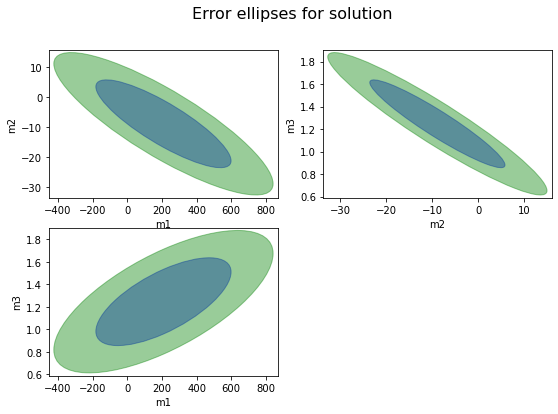

In [10]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

Cm = GtGinv # Covariance matrix of solution errors
print("Covariance matrix\n",Cm)

Corr = Cm 
D = np.sqrt(np.diag(Cm)) 
Dinv = np.linalg.inv(np.diag(D))
Corr = np.dot(Dinv,np.dot(Cm,Dinv)) #  Correlation matrix of solution errors
print("\nCorrelation matrix\n",Corr)

sig_param1 = np.sqrt(Cm[0,0])
sig_param2 = np.sqrt(Cm[1,1])
sig_param3 = np.sqrt(Cm[2,2])
print("\n Solution and 95% Confidence intervals ")
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[0],mls[0]-1.96*sig_param1,mls[0]+1.96*sig_param1))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[1],mls[1]-1.96*sig_param2,mls[1]+1.96*sig_param2))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[2],mls[2]-1.96*sig_param3,mls[2]+1.96*sig_param3))

# ----------------------------------------------------------------------------
# Plot covariance matrix from error distribution for each pair of solution parameters
# ----------------------------------------------------------------------------

CmProj01 = Cm[np.ix_([0,1],[0,1])]
CmProj02 = Cm[np.ix_([0,2],[0,2])]
CmProj12 = Cm[np.ix_([1,2],[1,2])]

fig = plt.figure(figsize=(9,6))
fig.suptitle("Error ellipses for solution", fontsize=16)

l68 = np.sqrt(stats.chi2.ppf(q=0.68,df=2)) # number of standard deviations equivalent to 68% confidence ellipse
l95 = np.sqrt(stats.chi2.ppf(q=0.95,df=2)) # number of standard deviations equivalent to 95% confidence ellipse
print(' Number of standard deviations for 68% Conf ellipse = ',l68)
print(' Number of standard deviations for 95% Conf ellipse = ',l95)

ax1 = plt.subplot("221")
pc.plot_cov_ellipse(CmProj01,mls[0:2], ax=ax1,nstd=l68,color='Blue',alpha=0.4,label="68% Confidence")
pc.plot_cov_ellipse(CmProj01,mls[0:2], ax=ax1,nstd=l95,color='Green',alpha=0.4,label="95% Confidence")
ax1.set_xlim(mls[0]-1.3*1.96*sig_param1,mls[0]+1.3*1.96*sig_param1)
ax1.set_ylim(mls[1]-1.3*1.96*sig_param2,mls[1]+1.3*1.96*sig_param2)
ax1.set_xlabel('m1')
ax1.set_ylabel('m2')

ax2 = plt.subplot("222")
pc.plot_cov_ellipse(CmProj12,mls[1:], ax=ax2,nstd=l68,color='Blue',alpha=0.4,label='68% Confidence')
pc.plot_cov_ellipse(CmProj12,mls[1:], ax=ax2,nstd=l95,color='Green',alpha=0.4,label='95% Confidence')
ax2.set_xlim(mls[1]-1.3*1.96*sig_param2,mls[1]+1.3*1.96*sig_param2)
ax2.set_ylim(mls[2]-1.3*1.96*sig_param3,mls[2]+1.3*1.96*sig_param3)
ax2.set_xlabel('m2')
ax2.set_ylabel('m3')

ax3 = plt.subplot("223")
pc.plot_cov_ellipse(CmProj02,[mls[0],mls[2]], ax=ax3,nstd=l68,color='Blue',alpha=0.4,label='68% Confidence')
pc.plot_cov_ellipse(CmProj02,[mls[0],mls[2]], ax=ax3,nstd=l95,color='Green',alpha=0.4,label='95% Confidence')
ax3.set_xlim(mls[0]-1.3*1.96*sig_param1,mls[0]+1.3*1.96*sig_param1)
ax3.set_ylim(mls[2]-1.3*1.96*sig_param3,mls[2]+1.3*1.96*sig_param3)
ax3.set_xlabel('m1')
ax3.set_ylabel('m3')

plt.show()

**Task 5:** Generate 1000 feasible solutions for the model parameters and for
    each one generate and plot the predicted curves, with the data and
    the true curve from the least squares solution.
    
If you multiply the `G` matrix by the model vector `m`, it will give you the predicted y values at the x values of the data. Using only these x values will create a crude plot of the curve, i.e. by joining together just 12 predicted y values. To get a smoother curve you can generate a new `G_fine` matrix using a much finer grid of x values between 1 and 120. This already exists in the array `x_fine`. If you build a matrix `G_fine` using `x_fine` it will be a $120\times 3$ matrix. By multiplying `G_fine`  by each of your feasible solutions `m` and then plotting the y values obtained, you will get a better representation of each oscillating curve.

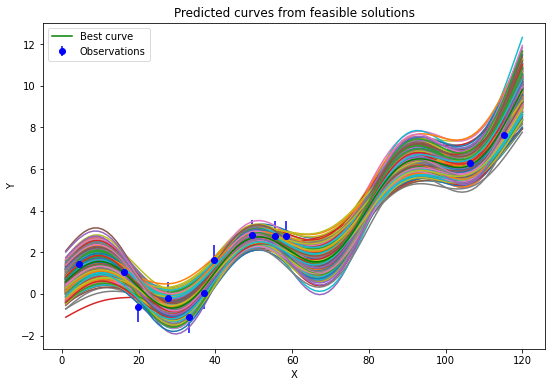

In [13]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# ----------------------------------------------------------------------------
# Calculate random draws from model error distribution for each pair of solution parameters
# ----------------------------------------------------------------------------

points = np.random.multivariate_normal(mean=mls, cov=Cm, size=500) # generate feasible solutions from model covariance matrix 
s = np.dot(G_true,np.transpose(points))

# ----------------------------------------------------------------------------
# Plot predicted polynomials for feasible solutions
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(9,6))
#ax.plot(x_true,s,color=[0.8,0.8,0.8])
ax.plot(x_true,s)
ax.errorbar(xobs,yobs,yerr=sigmay,fmt='o',color='b',label='Observations')
plt.title('Predicted curves from feasible solutions')
ax.plot(x_true, ypredicted,label='Best curve',color='g')
plt.legend(loc='upper left',framealpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
#print(ypredicted[0])

**Task 6** With feasible solutions calculated in this way we could investigate how the data constrain any other property of either the model parameter or the data. 

For example plot the histogram of the predicted curves sampled at $X=100$. What does this tell you about the predicted Y values at this value of X?

Now plot the histogram of the variable $z=m_1+m_2^2$ from the feasible solutions. What does this tell you about constraint on $z$ provided by the data? Note that we have not actually solved for $z$ directly, but found its histogram from the feasible values of the model parameters.

**Task 7**  Repeat the calculation of the model covariance matrix and 95%
    Confidence intervals but assuming data errors are smaller than they actually are. Set $\sigma_y = 0.25$. What
    do you notice about each these new error estimates? How would you
    rectify the situation to get reasonable model parameter errors?

Covariance matrix
 [[ 7.42902849e+03 -2.36172729e+02  5.02218959e+00]
 [-2.36172729e+02  1.05664769e+01 -2.63189998e-01]
 [ 5.02218959e+00 -2.63189998e-01  7.42830938e-03]]
 Solution and 95% Confidence intervals 

 Parameter 1 208.423 [ 39.487, 377.359]
 Parameter 2  -8.867 [-15.238,  -2.495]
 Parameter 3   1.247 [  1.078,   1.416]


/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


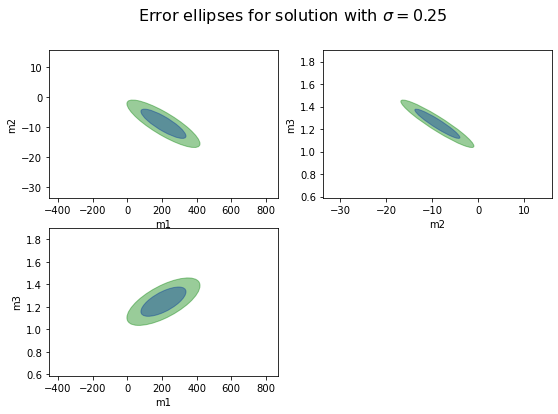

In [11]:
sigmanew = 0.25
Cdinv = np.eye(ndata)/(sigmanew**2) # Inverse Data covariance matrix
CmNew = np.linalg.inv(np.dot(np.dot(np.transpose(G), Cdinv), G)) # Inverse of G^TC_inv G
print("Covariance matrix\n",CmNew)

sig_param1new = np.sqrt(CmNew[0,0])
sig_param2new = np.sqrt(CmNew[1,1])
sig_param3new = np.sqrt(CmNew[2,2])
print(" Solution and 95% Confidence intervals \n")
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[0],mls[0]-1.96*sig_param1new,mls[0]+1.96*sig_param1new))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[1],mls[1]-1.96*sig_param2new,mls[1]+1.96*sig_param2new))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[2],mls[2]-1.96*sig_param3new,mls[2]+1.96*sig_param3new))

# ----------------------------------------------------------------------------
# Plot covariance matrix from error distribution for each pair of solution parameters
# ----------------------------------------------------------------------------

CmProj01 = CmNew[np.ix_([0,1],[0,1])]
CmProj02 = CmNew[np.ix_([0,2],[0,2])]
CmProj12 = CmNew[np.ix_([1,2],[1,2])]

fig = plt.figure(figsize=(9,6))
fig.suptitle("Error ellipses for solution with $\sigma=$"+repr(0.25), fontsize=16)

ax1 = plt.subplot("221")
pc.plot_cov_ellipse(CmProj01,mls[0:2], ax=ax1,nstd=l68,color='Blue',alpha=0.4,label="68% Confidence")
pc.plot_cov_ellipse(CmProj01,mls[0:2], ax=ax1,nstd=l95,color='Green',alpha=0.4,label="95% Confidence")
ax1.set_xlim(mls[0]-1.3*1.96*sig_param1,mls[0]+1.3*1.96*sig_param1)
ax1.set_ylim(mls[1]-1.3*1.96*sig_param2,mls[1]+1.3*1.96*sig_param2)
ax1.set_xlabel('m1')
ax1.set_ylabel('m2')

ax2 = plt.subplot("222")
pc.plot_cov_ellipse(CmProj12,mls[1:], ax=ax2,nstd=l68,color='Blue',alpha=0.4,label='68% Confidence')
pc.plot_cov_ellipse(CmProj12,mls[1:], ax=ax2,nstd=l95,color='Green',alpha=0.4,label='95% Confidence')
ax2.set_xlim(mls[1]-1.3*1.96*sig_param2,mls[1]+1.3*1.96*sig_param2)
ax2.set_ylim(mls[2]-1.3*1.96*sig_param3,mls[2]+1.3*1.96*sig_param3)
ax2.set_xlabel('m2')
ax2.set_ylabel('m3')

ax3 = plt.subplot("223")
pc.plot_cov_ellipse(CmProj02,[mls[0],mls[2]], ax=ax3,nstd=l68,color='Blue',alpha=0.4,label='68% Confidence')
pc.plot_cov_ellipse(CmProj02,[mls[0],mls[2]], ax=ax3,nstd=l95,color='Green',alpha=0.4,label='95% Confidence')
ax3.set_xlim(mls[0]-1.3*1.96*sig_param1,mls[0]+1.3*1.96*sig_param1)
ax3.set_ylim(mls[2]-1.3*1.96*sig_param3,mls[2]+1.3*1.96*sig_param3)
ax3.set_xlabel('m1')
ax3.set_ylabel('m3')

plt.show()
# I'd rectify by rescaling data errors to get Chi-square equal to 1.0

In [12]:
# scale factor for errors
chisqnew = np.dot(np.dot(np.transpose(r), Cdinv), r) # Calculate new Chi-square 
lam = np.sqrt(chisqnew/(ndata-len(mls)))
print(' Estimated scale factor to multiply errors = ',lam)
print(' Actual ratio of data error to true data error = ',sigmay/sigmanew)

 Estimated scale factor to multiply errors =  2.263918222322146
 Actual ratio of data error to true data error =  3.0


Let us now repeat the calculation and plotting of confidence ellipses using the adjusted errors.

Covariance matrix
 [[ 3.80761908e+04 -1.21046216e+03  2.57403575e+01]
 [-1.21046216e+03  5.41566357e+01 -1.34893446e+00]
 [ 2.57403575e+01 -1.34893446e+00  3.80725051e-02]]
 Solution and 95% Confidence intervals 

 Parameter 1 208.423 [-174.034, 590.881]
 Parameter 2  -8.867 [-23.290,   5.557]
 Parameter 3   1.247 [  0.865,   1.629]


/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/Users/malcolm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


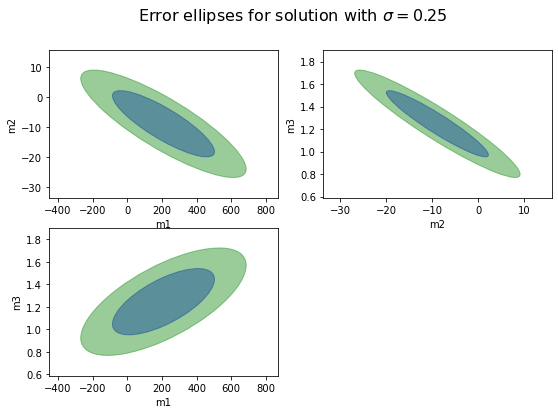

In [13]:
sigmanew = 0.25*lam
Cdinv = np.eye(ndata)/(sigmanew**2) # Inverse Data covariance matrix
CmNew = np.linalg.inv(np.dot(np.dot(np.transpose(G), Cdinv), G)) # Inverse of G^TC_inv G
print("Covariance matrix\n",CmNew)

sig_param1new = np.sqrt(CmNew[0,0])
sig_param2new = np.sqrt(CmNew[1,1])
sig_param3new = np.sqrt(CmNew[2,2])
print(" Solution and 95% Confidence intervals \n")
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[0],mls[0]-1.96*sig_param1new,mls[0]+1.96*sig_param1new))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[1],mls[1]-1.96*sig_param2new,mls[1]+1.96*sig_param2new))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[2],mls[2]-1.96*sig_param3new,mls[2]+1.96*sig_param3new))

# ----------------------------------------------------------------------------
# Plot covariance matrix from error distribution for each pair of solution parameters
# ----------------------------------------------------------------------------

CmProj01 = CmNew[np.ix_([0,1],[0,1])]
CmProj02 = CmNew[np.ix_([0,2],[0,2])]
CmProj12 = CmNew[np.ix_([1,2],[1,2])]

fig = plt.figure(figsize=(9,6))
fig.suptitle("Error ellipses for solution with $\sigma=$"+repr(0.25), fontsize=16)

ax1 = plt.subplot("221")
pc.plot_cov_ellipse(CmProj01,mls[0:2], ax=ax1,nstd=l68,color='Blue',alpha=0.4,label="68% Confidence")
pc.plot_cov_ellipse(CmProj01,mls[0:2], ax=ax1,nstd=l95,color='Green',alpha=0.4,label="95% Confidence")
ax1.set_xlim(mls[0]-1.3*1.96*sig_param1,mls[0]+1.3*1.96*sig_param1)
ax1.set_ylim(mls[1]-1.3*1.96*sig_param2,mls[1]+1.3*1.96*sig_param2)
ax1.set_xlabel('m1')
ax1.set_ylabel('m2')

ax2 = plt.subplot("222")
pc.plot_cov_ellipse(CmProj12,mls[1:], ax=ax2,nstd=l68,color='Blue',alpha=0.4,label='68% Confidence')
pc.plot_cov_ellipse(CmProj12,mls[1:], ax=ax2,nstd=l95,color='Green',alpha=0.4,label='95% Confidence')
ax2.set_xlim(mls[1]-1.3*1.96*sig_param2,mls[1]+1.3*1.96*sig_param2)
ax2.set_ylim(mls[2]-1.3*1.96*sig_param3,mls[2]+1.3*1.96*sig_param3)
ax2.set_xlabel('m2')
ax2.set_ylabel('m3')

ax3 = plt.subplot("223")
pc.plot_cov_ellipse(CmProj02,[mls[0],mls[2]], ax=ax3,nstd=l68,color='Blue',alpha=0.4,label='68% Confidence')
pc.plot_cov_ellipse(CmProj02,[mls[0],mls[2]], ax=ax3,nstd=l95,color='Green',alpha=0.4,label='95% Confidence')
ax3.set_xlim(mls[0]-1.3*1.96*sig_param1,mls[0]+1.3*1.96*sig_param1)
ax3.set_ylim(mls[2]-1.3*1.96*sig_param3,mls[2]+1.3*1.96*sig_param3)
ax3.set_xlabel('m1')
ax3.set_ylabel('m3')

plt.show()
# I'd rectify by rescaling data errors to get Chi-square equal to 1.0